In [322]:
import re
import ast
import json
import math
from os import path
import pandas as pd
import numpy as np
from numpy import cumsum
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation, CompoundLocation
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import MutableSeq
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from collections import Counter

In [212]:
def readin_virus_config(virus):
    """
    Read in the config json file specific to this virus
    """
    config_json = f'config/adaptive_evo_config_{virus}.json'
    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [ ]:
    #split the full alignment into subalignments of sequences sampled within time windows
#     year_subalignment_dict = {}
#     years = []

#     with open('testing_alignment.fasta', "r") as aligned_handle:
#         for isolate in SeqIO.parse(aligned_handle, "fasta"):
#             if 'outgroup' in isolate.id:
#                 outgroup_seq = isolate.seq
#             else:
#                 isolate_year = isolate.id.split('_')[0]
#                 if isolate_year in year_subalignment_dict.keys():
#                     year_subalignment_dict[isolate_year].append(isolate)
#                 else:
#                     years.append(isolate_year)
#                     year_subalignment_dict[isolate_year] = MultipleSeqAlignment([isolate])

In [312]:
def get_subalignments_and_outgroup(virus, subtype, gene, window, min_seqs, year_max, year_min, outgroup_type):
    """
    Read in metadata and alignment info from a nextstrain build
    
    Divide alignment into time windows (specified by window)
    -Each window must have at least min_seqs in it
    -Can limit analysis to certain range of years using year_max and year_min
    
    Also, find the initial outgroup sequence (which will be updated at subsequent timepoints 
    to allow multiple mutations at the same codon)
    
    Can specify outgroup_type to be 'root' (outgroup sequence will be the root of the tree) or 
    'consensus' (outgroup sequence will be the consensus sequence at the first timepoint in the alignment)
    """
    configs = readin_virus_config(virus)
    standard_gene = standardize_gene_name(virus, gene)
    
    #some dengue files are shared between all genotypes of the same serotype
    if virus=='dengue':
        serotype = subtype.split('_')[0]
    else:
        serotype = False
    

    #Find reference, alignment and meta files (some sub-genic regions may use files from a gene or a whole genome)
    if 'specify_location' in configs[standard_gene].keys():
        parent_gene = configs[standard_gene]['specify_location']['parent_gene']
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
        #some are comma-separated, some are tab-separated
        metafile_sep = configs['metafile_sep']
        root_seq_file = configs['root_seq_file'].format(virus=virus, subtype=subtype, gene=parent_gene)
    else:
        alignment_file = configs['alignment_file'].format(virus=virus, subtype=subtype, gene=gene)
        meta_file = configs['meta_file'].format(virus=virus, subtype=subtype, gene=gene)
        metafile_sep = configs['metafile_sep']
        root_seq_file = configs['root_seq_file'].format(virus=virus, subtype=subtype, gene=gene)
        #dengue reference files are shared among serotypes
        if serotype:
            reference_file = configs['reference_file'].format(virus=virus, subtype=serotype, gene=gene)
        else:
            reference_file = configs['reference_file'].format(virus=virus, subtype=subtype, gene=gene)
    
    # if a minimum year to use is supplied in config, limit seqs to this
    if 'min_year' in configs.keys():
        year_min = int(configs['min_year'])
    
    #Find gene location, if domain is sub-genic or reference file contains multiple genes
    gene_location = False
    #If domain is sub-genic, fetch its position (within genome or parent gene) from config file


    if 'specify_location' in configs[standard_gene].keys():
        if subtype==None:
            gene_location_key = "location"
        else:
            #dengue reference files and locations are shared among serotypes
            if serotype:
                gene_location_key = "location_"+str(serotype)
            else:
                gene_location_key = "location_"+str(subtype)
            
        gene_location_list = ast.literal_eval(configs[standard_gene]['specify_location'][gene_location_key])
        #Need to deal with domains the are not contiguous
        if len(gene_location_list)==1:
            gene_location = SeqFeature(FeatureLocation(gene_location_list[0][0], gene_location_list[0][1]))
        else:
            compound_locations = []
            for location in gene_location_list:
                compound_locations.append(FeatureLocation(location[0], location[1]))
            gene_location = CompoundLocation(compound_locations)

    #Find gene location from reference files
    else:
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if 'gene' in feature.qualifiers.keys():
                        if feature.qualifiers['gene'][0].lower() == gene.lower():
                            gene_location = feature.location
                    elif feature.qualifiers['product'][0].lower() == gene.lower():
                        gene_location = feature.location                

    #Subset data based on time windows
    meta = pd.read_csv(meta_file, sep = metafile_sep)
    #drop incomplete date data
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta = meta[meta["date"].str.contains("20XX")==False]
    meta = meta[meta["date"].str.contains("36-0")==False]
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    #Remove egg- and cell-passaged strains
    meta.drop(meta[meta['strain'].str[-4:]=='-egg'].index, inplace=True)
    meta.drop(meta[meta['strain'].str[-5:]=='-cell'].index, inplace=True)
    
    #Limit meta data to only strains in alignment file
    aligned_isolates = []
    with open(alignment_file, "r") as aligned_handle:
        for isolate in SeqIO.parse(aligned_handle, "fasta"):
            aligned_isolates.append(isolate.id)
    aligned_isolates_df = pd.DataFrame(aligned_isolates, columns=['strain'])
    meta = meta.merge(aligned_isolates_df, on='strain', how='inner')
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    

    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}
    
    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}

    
    for years, subset_viruses in virus_time_subset.items():

        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False
        

        with open(alignment_file, "r") as aligned_handle:
            for isolate in SeqIO.parse(aligned_handle, "fasta"):
                if isolate.id in first_window_strains:
                    if gene_location:
                        gene_record = SeqRecord(seq = gene_location.extract(isolate.seq), 
                                                id = isolate.id, description = gene)
                    else:
                        gene_record = SeqRecord(seq = isolate.seq, 
                                                id = isolate.id, description = gene)
                    first_window_sequences.append(gene_record)
                if isolate.id in subset_viruses:
                    if gene_location:
                        if years in alignment_time_subset.keys():
                            alignment_time_subset[years].append(SeqRecord(seq=gene_location.extract(isolate.seq), id=isolate.id))
                        else:
                            alignment_time_subset[years] = MultipleSeqAlignment([
                                SeqRecord(seq=gene_location.extract(isolate.seq), id=isolate.id)])
                    else:
                        if years in alignment_time_subset.keys():
                            alignment_time_subset[years].append(SeqRecord(seq=isolate.seq, id=isolate.id))
                        else:
                            alignment_time_subset[years] = MultipleSeqAlignment([SeqRecord(seq=isolate.seq, id=isolate.id)])
                        
    if outgroup_type == 'root':
        with open(root_seq_file) as json_handle:
            root_seq_dict = json.load(json_handle)
        outgroup_seq = gene_location.extract(Seq(root_seq_dict['nuc']))
#         outgroup_seq_aa = root_seq_dict[gene]

            
            
            
    elif outgroup_type == 'consensus':
        first_window_alignment = MultipleSeqAlignment(first_window_sequences)
        if virus=='rsv':
            outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).gap_consensus(ambiguous ='N')
        else:
            outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')

    has_dup = find_duplication(outgroup_seq)

    #if virus has duplication, want to run Bhatt on entire alignment excluding dup, 
    #and then separately on the duplicated sequence to look at evolution occurring on top of it

    if has_dup:
        outgroup_seq, outgroup_seq_aa, alignment_time_subset = adjust_for_duplications(outgroup_seq, alignment_time_subset)
    else:
        outgroup_seq_aa = outgroup_seq.translate()
    
    
    return alignment_time_subset, outgroup_seq, year_windows 


In [214]:
def find_duplication(outgroup_seq):
    """
    Duplication events (or any insertions) will be signified in the outgroup sequence 
    by a series of consecutive --- placeholders. Find if there is a duplication in this 
    evolution of this virus.
    """
    has_dup = False
    outgroup_seq_str = str(outgroup_seq)
    #if there are ---s in the outgroup_seq, find where they are
    #say that insertion/duplication has to be at least 3 codons long
    if re.search("-{9,}", outgroup_seq_str):
        has_dup=True
        
        
    return has_dup

In [303]:
def adjust_for_duplications(outgroup_seq, alignment_time_subset):
    """
    Find the position and length of the duplication.
    Remove the duplicated region from the outgroup sequence and the every sequence in the alignment.
    Evolution on the duplicated region will be considered separately because the outgroup consensus 
    for this region needs to done from the first timepoint where there are sequences with the duplication
    """

    outgroup_seq_str = str(outgroup_seq)
    #find where the duplication is by locating ---s in the outgroup_seq
    if re.search("-{9,}", outgroup_seq_str):
        dup_start, dup_end = [(x.start(),x.end()) for x in re.finditer(r'-{9,}', outgroup_seq_str)][0]


    outgroup_wo_dup = Seq(outgroup_seq_str[:dup_start]+outgroup_seq_str[dup_end:])
    outgroup_wo_dup_aa = outgroup_wo_dup.translate()

    # remove the duplicated portion from the main alignment
    alignment_time_subset_wo_dup = {}
    for dates, aligned_seqs in alignment_time_subset.items():
        aligned_seqs_wo_dup = aligned_seqs[:,:dup_start]+ aligned_seqs[:, dup_end:]
        alignment_time_subset_wo_dup[dates] = aligned_seqs_wo_dup
    
        
    
    return outgroup_wo_dup, outgroup_wo_dup_aa, alignment_time_subset_wo_dup


In [318]:
def get_mratio(virus, subtype, gene, midfreq_high, midfreq_low, min_seqs, year_max, year_min, outgroup_type):
    """
    M=rm/sm 
    M ratio not expected to vary through time provided that long-term effective 
    population sizes remain sufficiently large
    For each gene, calculate M by combining site count among time points. If the gene is "antigenic gene", 
    then calculate m_ratio from nonantigenic gene
    """
    
    configs = readin_virus_config(virus)
    nonantigenic_gene = configs['nonantigenic_gene']
    
    if standardize_gene_name(virus, gene) =='ha_protein' or standardize_gene_name(virus, gene) =='receptor_binding':
        year_subalignment_dict, outgroup_seq, years = get_subalignments_and_outgroup(virus, subtype, 
                                                                                     nonantigenic_gene, 
                                                                                     'all', min_seqs, 
                                                                                     year_max, year_min, 
                                                                                     outgroup_type)
    else:
        year_subalignment_dict, outgroup_seq, years = get_subalignments_and_outgroup(virus, subtype, 
                                                                                     gene, 
                                                                                     'all', min_seqs, 
                                                                                     year_max, year_min, 
                                                                                     outgroup_type)
    
    all_years_window = list(year_subalignment_dict.keys())[0]
    full_alignment_dict = year_subalignment_dict[all_years_window]
    
    fixed_mutations, rf, sf, rh, sh, rm, sm, rl, sl = find_site_class_counts(outgroup_seq, full_alignment_dict, 
                                                                      midfreq_high, midfreq_low)
    
    if sm ==0:
        sm = 0.00000000000000001
    m_ratio = rm/sm

    
    return m_ratio

In [328]:
def calculate_rate_of_adaptation(year_subalignment_dict, outgroup_seq, m_ratio, midfreq_high, midfreq_low):
    """
    Calculate adaptive mutations per time period and rate of adaptation over time
    """

    #initialize list to record estimate of adaptive mutations at each timepoint
    adaptive_mutations_per_timewindow = []
    
    window_midpoints = []

    #for each window in the total alignment
    #find mutations compared to the outgroup
    #and update the outgroup if there were any fixations
    for year_window, subalignment in year_subalignment_dict.items():
        window_start = int(year_window[0:4])
        window_end = int(year_window[-4:])
        window_midpoints.append((window_start + window_end)/2)
        
        
#         subalignment = year_subalignment_dict[year_window]
        fixed_mutations, rf, sf, rh, sh, rm, sm, rl, sl = find_site_class_counts(outgroup_seq, subalignment, 
                                                                      midfreq_high, midfreq_low)
    

        af = rf - sf*(m_ratio)
        ah = rh - sh*(m_ratio)
        a = af + ah
        #to be conservative, set neg a values to zero, according to Bhatt 2011
        if a<0:
            a=0.0

        adaptive_mutations_per_timewindow.append(a)
        #update the outgroup sequence before the next time window
        outgroup_seq = update_outgroup_seq(outgroup_seq, fixed_mutations)


    #because this method updates the outgroup sequence with each fixation and 
    #then compares the alignment to that, the measure of 'a' will be during 
    #the time window only, not cumulative. The Bhatt method outputs 'a' as an 
    #accumulation of adaptive mutations between the first timepoint and the current one.
    #add all previous windows to get accumulation of a
    adaptive_mutations_accumulated = list(cumsum(adaptive_mutations_per_timewindow))

    gene_length_in_codons = len(outgroup_seq)/3
    adaptive_muts_per_codon = [x/gene_length_in_codons for x in adaptive_mutations_accumulated]


    #find rate of adaptation, in adaptive muts per year
    rate_of_adaptation, intercept, r_value, p_value, std_err = stats.linregress([float(x) for x in window_midpoints], adaptive_mutations_accumulated)
    #find rate of adaptation per codon (per year)
    rate_of_adaptation_per_codon = rate_of_adaptation/gene_length_in_codons

    return window_midpoints, gene_length_in_codons, adaptive_mutations_accumulated, adaptive_muts_per_codon, rate_of_adaptation, rate_of_adaptation_per_codon


In [189]:
def update_outgroup_seq(outgroup_seq, fixed_mutations):
    """
    To deal with sites that have mutated multiple times, need to update the outgroup_seq 
    to apply each fixation that occurred during the last time window
    """
    new_outgroup_seq = MutableSeq(outgroup_seq)
    
    for pos, mut in fixed_mutations.items():
        new_outgroup_seq[pos] = mut
    
    return new_outgroup_seq

In [186]:
def find_site_class_counts(outgroup_seq, aligned_seqs, midfreq_high, midfreq_low):
    """
    Compare an alignment (usually a subalignment) to the outgroup sequence to find mutations.
    
    Find how prevalent these mutations within the time window and whether they are silent or replacement mutations.
    """
    
    #get all codons in the outgroup_seq. This will be used to determine silent and replacement mutations
    nt_codon_mapper = get_nt_codon_mapper(outgroup_seq)
    
    #initialize counts of classes of mutations 
    rf=0
    sf=0 
    rh=0
    sh=0
    rm=0
    sm=0
    rl=0 
    sl=0
    
    #initialize dict to keep track of all fixations 
    #and high-frequency polymorphisms (syn and nonsyn)
    #that occurred during this time window
    #key is position and value is the fixed mutation
    fixed_mutations = {}
    
    #walk through the alignment, site-wise and look for mutations between the aligned_seqs and the outgroup_seq
    for i in range(len(outgroup_seq)):
        outgroup_nt_at_pos_i = outgroup_seq[i]
        #skip ambiguous 
        if outgroup_nt_at_pos_i in ['A', 'C', 'G', 'T']:
            aligned_nts_at_pos_i = aligned_seqs[:,i]
            #remove ambiguous sequencing
            aligned_nts_at_pos_i = ''.join(c for c in aligned_nts_at_pos_i if c in 'ATCG')
            
            #get the number of isolates with unambiguous info at this nt pos
            num_unambiguous_nt = len(aligned_nts_at_pos_i)
            
            
            if num_unambiguous_nt!=0:
                #get fixation score (Fi) and polymorphism score(Pi) at this position
                #this gives multi-state polymophic sites a probability that there was an 
                #intermediate fixation and then another mutation and a probability that 
                #there were two separate mutations (not on top of each other) 
                #sites with no mutations will get an Fi and Pi score of 0
                Fi, Pi = fixation_polymorphism_score(outgroup_nt_at_pos_i, aligned_nts_at_pos_i)
                
                
                #get replacement (Ri) and silent (Si) scores
                #Ri is the number of ingroup (alignment) nts that would cause a nonsyn change in the outgroup. 
                #Silent is 1-Ri
                outgroup_codon, codon_pos = nt_codon_mapper[i]
                Ri, Si = replacement_silent_score(aligned_nts_at_pos_i, 
                                                  outgroup_codon, codon_pos)
                

                #get the frequency bin (high-, mid- or low-, depending on how the amount of polymorphisms at this position)
                #if there are multiple mutations at this site, need to look at them separately
                muts_at_position = set([x for x in aligned_nts_at_pos_i if x!=outgroup_nt_at_pos_i])
                
                #if there are mutations at this position
                if len(muts_at_position)!=0:
                    #for each mutation at this position
                    for m in muts_at_position:
                        #determine whether it is synon or nonsynon
                        mutation_type = determine_replacement_silent(m, outgroup_codon, codon_pos)
                        
                        num_polymorphic = len([x for x in aligned_nts_at_pos_i if x==m])
                        fraction_polymorphic = num_polymorphic/num_unambiguous_nt
                        frequency_bin = frequency_binning(fraction_polymorphic, midfreq_high, midfreq_low)
                        
                        if mutation_type=='nonsynonymous':
                            rf+=Fi*Ri
                            if frequency_bin =='f':
                                fixed_mutations[i] = m
                            elif frequency_bin=='h':
                                rh+=Pi*Ri
                                fixed_mutations[i] = m
                            elif frequency_bin=='m':
                                rm+=Pi*Ri
                            elif frequency_bin=='l':
                                rl+=Pi*Ri
                        elif mutation_type=='synonymous':
                            sf+=Fi*Si
                            if frequency_bin =='f':
                                fixed_mutations[i] = m
                            elif frequency_bin=='h':
                                sh+=Pi*Si
                                fixed_mutations[i] = m
                            elif frequency_bin=='m':
                                sm+=Pi*Si
                            elif frequency_bin=='l':
                                sl+=Pi*Si
                                                
                        
        #ignore this site if the outgroup_seq is ambiguous at this position
        else:
            pass
        
        
    return fixed_mutations, rf, sf, rh, sh, rm, sm, rl, sl



In [127]:
def determine_replacement_silent(mut, outgroup_codon, codon_pos):
    """
    Determine whether a mutation is synonymous or nonsynonymous
    """
    #translate the outgroup codon
    outgroup_aa = outgroup_codon.translate()
    

    mutated_codon = MutableSeq(outgroup_codon)
    mutated_codon[codon_pos] = mut
    mutated_aa = mutated_codon.translate()
    if mutated_aa!=outgroup_aa:
        mutation_type ='nonsynonymous'
    elif mutated_aa==outgroup_aa:
        mutation_type ='synonymous'

    
    return mutation_type

In [117]:
def replacement_silent_score(ingroup_nts, outgroup_codon, codon_pos):
    """
    Find whether mutations at this site are synonymous or nonsynonymous 
    and return the silent(Si) and replacement (Ri) scores
    
    Ri is the number of seqs in the alignment with a nonsynonymous mutation at this position
    """
    
    #translate the outgroup codon
    outgroup_aa = outgroup_codon.translate()
    
    nonsyn_muts_count=0
    #see how many ingroup_nts result in a nonsynonymous change
    for x in ingroup_nts:
        mutated_codon = MutableSeq(outgroup_codon)
        mutated_codon[codon_pos] = x
        mutated_aa = mutated_codon.translate()
        if mutated_aa!=outgroup_aa:
            nonsyn_muts_count+=1
    
    Ri= nonsyn_muts_count/len(ingroup_nts)
    Si= 1-Ri
    
    return Ri, Si

In [87]:
def get_nt_codon_mapper(seq):
    """
    Split the supplied sequence up into a list of codons
    Return an error if not divisble by 3
    
    Return a dictionary mapping each nucleotide position to the 
    sequence of codon it belongs to in the provided seq
    
    Format of returned mapper is {nt_pos:['codon_seq', pos_within_codon]}
    """
    if len(seq) %3 != 0:
        print('Sequence not divisible by 3. Check specific location')
    
    
    nt_codon_mapper = {}
    for i in range(0, len(seq), 3):
        nt_codon_mapper[i] = [seq[i:i+3], 0]
        nt_codon_mapper[i+1] = [seq[i:i+3], 1]
        nt_codon_mapper[i+2] = [seq[i:i+3], 2]
        
        
    return nt_codon_mapper

In [91]:
def frequency_binning(x, midfreq_high, midfreq_low):
    """
    Bin polymorpisms by frequency
    """

    #nan frequencies are when there is no sequence coverage at the given position
    if math.isnan(x):
        f_bin = float('nan')
    else:
        if x == 1.0:
            f_bin = 'f'
        elif x>=midfreq_high:
            f_bin = 'h'
        elif x<midfreq_high and x>=midfreq_low:
            f_bin = 'm'
        elif x<midfreq_low:
            f_bin='l'

    return f_bin

In [70]:
def determine_site_type(outgroup_nt, ingroup_nts):
    """
    Determine site type in order to assign a fixation and polymorphism score
    """
    #find set of all different nts that exist at this position in the alignment
    ingroup_bases = set(ingroup_nts)

    #all ingroup bases are identical
    if len(ingroup_bases) == 1:
        if outgroup_nt in ingroup_bases:
            site_type = 1
        elif outgroup_nt not in ingroup_bases:
            site_type = 2

    #2 different bases in ingroup
    elif len(ingroup_bases) == 2:
        if outgroup_nt in ingroup_bases:
            site_type = 3
        elif outgroup_nt not in ingroup_bases:
            site_type = 4

    #3 different bases in ingroup
    elif len(ingroup_bases) == 3:
        if outgroup_nt in ingroup_bases:
            site_type = 5
        elif outgroup_nt not in ingroup_bases:
            site_type = 6

    #4 different bases in ingroup
    elif len(ingroup_bases) == 4:
        site_type = 7
    
    
    return site_type

In [103]:
def fixation_polymorphism_score(outgroup_nt, ingroup_nts):
    """
    Assign a fixation and polymorphism score, as per Bhatt 2010.
    
    Meant to deal with multiple-state polymorphisms (meaning 
    that more than just outgroup base and one other base are observed at a given site)
    """
    site_type = determine_site_type(outgroup_nt, ingroup_nts)

    
    if site_type == 1:
        Fi = 0
        Pi = 0
    elif site_type == 2:
        Fi = 1
        Pi = 0
    elif site_type in [3,5,7]:
        Fi = 0
        Pi = 1
    elif site_type == 4:
        Fi = 0.5
        Pi = 0.5
    elif site_type == 6:
        Fi = (1/3)
        Pi = (2/3)
    
    return Fi, Pi

In [205]:
def standardize_gene_name_reverse(virus, gene):
    
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'receptor_binding', 'membrane_fusion']
    gene_names = {x: configs[x]['virus_gene'] for x in genes}
    
    return gene_names[gene]

In [206]:
def standardize_gene_name(virus, gene):
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'receptor_binding', 'membrane_fusion']
    gene_names = {configs[x]['virus_gene']:x for x in genes}
    
    return gene_names[gene]

In [320]:
def get_adaptation_results(virus, subtype, gene, window, min_seqs, year_max, year_min, 
                           midfreq_high, midfreq_low, outgroup_type):
    """
    If rates of adaptation have already been calculated for this virus/gene, just read in the saved results. 
    Otherwise, run the analysis and then save the results
    """
    
    data_to_plot = []
    
    
    if subtype:
        virus_and_subtype = virus+'_'+subtype
        save_filename = f'rate_of_adaptation_results/{virus}_{subtype}_{gene}_AdaptationResults.json'
    else:
        virus_and_subtype = virus
        save_filename = f'rate_of_adaptation_results/{virus}_{gene}_AdaptationResults.json'
    
    #find if the results have already been saved
    if path.exists(save_filename):
        with open(save_filename) as json_handle:
            json_dict = json.load(json_handle)
            (window_midpoints, gene_length_in_codons, 
             adaptive_mutations_accumulated, 
             adaptive_muts_per_codon, rate_of_adaptation, 
             rate_of_adaptation_per_codon, 
             rate_per_codon_scientific) = (json_dict['window_midpoints'], 
                                              json_dict['gene_length_in_codons'], 
                                              json_dict['adaptive_mutations_accumulated'], 
                                              json_dict['adaptive_muts_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['rate_of_adaptation_per_codon'], 
                                           json_dict['adaptive_muts_per_codon_per_year_scientific'])
        
    #otherwise, run the analysis and then save the results
    else:
        year_subalignment_dict, outgroup_seq, years = get_subalignments_and_outgroup(virus, subtype, gene, 
                                                                                     window, min_seqs, 
                                                                                     year_max, year_min, outgroup_type)
        
        m_ratio = get_mratio(virus, subtype, gene, midfreq_high, midfreq_low, min_seqs, year_max, year_min, outgroup_type)

        (window_midpoints, gene_length_in_codons, 
         adaptive_mutations_accumulated, 
         adaptive_muts_per_codon, rate_of_adaptation, 
         rate_of_adaptation_per_codon) = calculate_rate_of_adaptation(year_subalignment_dict, outgroup_seq, 
                                                                      m_ratio,
                                                                      midfreq_high, midfreq_low)
        rate_per_codon_scientific = rate_of_adaptation_per_codon * (10**3)
        #store estimates of adaptation
        save_json = {'virus': virus, 'subtype':subtype, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                     'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                     'years':years,'window_midpoints':window_midpoints, 'gene_length_in_codons':gene_length_in_codons, 
                     'adaptive_mutations_accumulated':adaptive_mutations_accumulated, 
                     'adaptive_muts_per_codon': adaptive_muts_per_codon,
                     'rate_of_adaptation':rate_of_adaptation, 'rate_of_adaptation_per_codon':rate_of_adaptation_per_codon, 
                     'adaptive_muts_per_codon_per_year_scientific':rate_per_codon_scientific}
        with open(save_filename, 'w') as outfile:
            json.dump(save_json, outfile)

    data_to_plot.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype':virus_and_subtype, 
                         'gene': gene, 'standard_gene': standardize_gene_name(virus, gene),
                         'window_midpoints':window_midpoints,
                         'adaptive_muts_per_year': rate_of_adaptation, 
                         'adaptive_muts_per_codon_per_year': rate_of_adaptation_per_codon, 
                         'adaptive_muts_per_codon_per_year_scientific': rate_per_codon_scientific})
        

    return data_to_plot
    

In [325]:
#calculated as slope of adaptive subs per codon
def compare_viruses_adaptive_rate(viruses, standard_genes=['polymerase', 'membrane_fusion', 'receptor_binding'], 
                                  exclude=None,
                                  window=3, min_seqs=2, bootstrap=False, 
                                  midfreq_high=0.75, midfreq_low=0.15, year_max=None, year_min=None, 
                                  outgroup_type='root', filename=None):
    

    
    data_to_plot = []
    color_map = {}
    virus_families = {}
    
    virus_names_legible = {}
    
    for virus in viruses:
        
        configs = readin_virus_config(virus)
        genes = [standardize_gene_name_reverse(virus, x) for x in standard_genes]
        
        if configs['subtype']=='True':
            subtypes = configs['subtypes']
            for subtype in subtypes:
                virus_and_sub = virus+'_'+subtype
                color_map[virus_and_sub] = configs['color'][subtype]
                virus_families[virus_and_sub] = configs['virus_family']
                virus_names_legible[virus_and_sub] = configs['legible_name'][subtype]
                
                for gene in genes:
                    if gene!="None":
                        data_to_plot+=get_adaptation_results(virus, subtype, gene, window, min_seqs, year_max, year_min, 
                                                               midfreq_high, midfreq_low, outgroup_type)

        else:
            subtype=None
            color_map[virus] = configs['color']
            virus_families[virus] = configs['virus_family']
            virus_names_legible[virus] = configs['legible_name']
            for gene in genes:
                if gene!="None":
                    data_to_plot+=get_adaptation_results(virus, subtype, gene, window, min_seqs, year_max, year_min, 
                                                               midfreq_high, midfreq_low, outgroup_type)

    
    df_to_plot = pd.DataFrame(data_to_plot)
    
    if exclude!=None:
        for e in exclude:
            df_to_plot = df_to_plot[df_to_plot['virus_and_subtype']!=e]
            virus_families = {k:v for k,v in virus_families.items() if k not in exclude}
    
    viruses_and_subtypes = list(df_to_plot['virus_and_subtype'].unique())

    
    #make subplot heights relative to max y-axis value
    gene_yranges = []
    for gene in standard_genes:
        if bootstrap:
            max_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['upper_95ci'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['gene']==gene]['lower_95ci'].min()
        else:
            max_rate_for_gene = df_to_plot[df_to_plot['standard_gene']==gene]['adaptive_muts_per_codon_per_year_scientific'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['standard_gene']==gene]['adaptive_muts_per_codon_per_year_scientific'].min()
        yrange = max_rate_for_gene - min_rate_for_gene
        gene_yranges.append(yrange)
        
    height_ratios= [x/max(gene_yranges) for x in gene_yranges]
        
    fig, axs = plt.subplots(len(standard_genes), 1, figsize=(len(viruses_and_subtypes)*0.5,10), 
                            gridspec_kw={'height_ratios':height_ratios}, sharex=True)        
    
    #legible gene labels
    genes_legible = {'polymerase': 'Polymerase', 'receptor_binding': 'Receptor Binding', 
                        'membrane_fusion': 'Membrane Fusion'}
    
    #make x-coordinates for each virus-subtype
    #cannot figure out how to do custom error bars in seaborn, which is why I'm doing it this way
    x_coords = {}
    all_x_ticks = []
    last_coord = 0.0
    spacing = {**{x:0.2 for x in range(1,8)}, **{y:0.3 for y in range(8,12)}, 
               **{z:0.5 for z in range(12,20)}, **{a:0.8 for a in range(20,35)}}
    #squish spacing between dengue genotypes of same serotype
    squished_spacing = {**{x:0.1 for x in range(1,8)}, **{y:0.1 for y in range(8,12)}, 
                        **{z:0.2 for z in range(12,20)}, **{a:0.28 for a in range(20,35)}}
    height_all_subplots = 0.6
    
    dengue_serotypes_seen = []
    for v in viruses_and_subtypes:
        if 'dengue' in v:
            if v.split('_')[1] in dengue_serotypes_seen:
                last_coord+=squished_spacing[len(viruses_and_subtypes)]
                x_coords[v] = last_coord
                all_x_ticks.append(last_coord)
            else:
                dengue_serotypes_seen.append(v.split('_')[1])
                last_coord+=spacing[len(viruses_and_subtypes)]
                x_coords[v] = last_coord
                all_x_ticks.append(last_coord)
        else:
            last_coord+=spacing[len(viruses_and_subtypes)]
            x_coords[v] = last_coord
            all_x_ticks.append(last_coord)

    for i in range(len(standard_genes)):
        gene = standard_genes[i]
        
        if bootstrap:
            max_rate_for_gene = df_to_plot[df_to_plot['standard_gene']==gene]['upper_95ci'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['standard_gene']==gene]['lower_95ci'].min()
        else:
            max_rate_for_gene = df_to_plot[df_to_plot['standard_gene']==gene]['adaptive_muts_per_codon_per_year_scientific'].max()
            min_rate_for_gene = df_to_plot[df_to_plot['standard_gene']==gene]['adaptive_muts_per_codon_per_year_scientific'].min()
        yaxis_max= max_rate_for_gene+0.1
        yaxis_min= min_rate_for_gene-0.1
        
        
        axs[i].set_ylim([yaxis_min, yaxis_max])
        height_all_subplots+=(yaxis_max-yaxis_min)
        
        for virus_subtype in viruses_and_subtypes:
            #allow some viruses to not have some of the genes (aka membrane fusion)
            if len(df_to_plot[(df_to_plot['standard_gene']==gene)&(df_to_plot['virus_and_subtype']==virus_subtype)])!=0:
                x = x_coords[virus_subtype]
                df_row = df_to_plot[(df_to_plot['standard_gene']==gene)&(df_to_plot['virus_and_subtype']==virus_subtype)]
                y = float(df_row['adaptive_muts_per_codon_per_year_scientific'])
                if bootstrap:
                    err_lower = float(df_row['lower_95ci'])
                    err_upper = float(df_row['upper_95ci'])
                    axs[i].vlines(x, err_lower, err_upper, color_map[virus_subtype])
                axs[i].plot(x, y, 'o', ms=12, color=color_map[virus_subtype])
        
        axs[i].tick_params(axis='x',size=0)
        axs[i].set_xticklabels([])
        axs[i].text(0.0, yaxis_max+0.2, genes_legible[gene], size=16, color='#878787')
        
        if i == 1:
            axs[i].text(-len(viruses_and_subtypes)*0.1, height_all_subplots*0.5, r'Adaptive Muts per Codon per Year $(x 10^{-3})$', 
                        size=16, rotation='vertical', va='center')
            
    plt.rcParams['ytick.labelsize']=14
    plt.subplots_adjust(hspace=0.3)

    x_coords = {virus_names_legible[k]:v for k,v in x_coords.items()}
    
    num_family_members = dict(Counter(list(virus_families.values())))
    used_families = []
    #manual offset for family labels
    family_text_offset = {'paramyxovirus':-0.6,'orthomyxovirus':0.2,'coronavirus':0.0,
                          'pneumovirus':-0.6,'flavivirus':0.8, 'picornavirus':-1.4, 'caliciviridae':-1.0}

    virus_families = {virus_names_legible[k]:v for k,v in virus_families.items()}
    
    for virus_subtype in viruses_and_subtypes:
        virus_name = virus_names_legible[virus_subtype]
        x = x_coords[virus_name]
        if virus_families[virus_name] not in used_families:
            virus_family = virus_families[virus_name]
            if 'Dengue' in virus_name:
                bar_length = spacing[len(viruses_and_subtypes)]*4+squished_spacing[len(viruses_and_subtypes)]*(num_family_members[virus_family]-4)
            else:
                bar_length = spacing[len(viruses_and_subtypes)]*num_family_members[virus_family]
            offset = spacing[len(viruses_and_subtypes)]
            axs[-1].plot([x-offset+0.1, x+bar_length-offset-0.1], [-height_all_subplots*0.33, -height_all_subplots*0.33], 
                         color=color_map[virus_subtype], clip_on=False, lw=3.0)
            axs[-1].text(x+offset+family_text_offset[virus_family], (-height_all_subplots*0.33-0.2),
                                       virus_family, color=color_map[virus_subtype], rotation=15, ha='right', rotation_mode='anchor')
            used_families.append(virus_family)
            
    #label viruses on bottom plot
    #want to condense names for some viruses to make x-axis less busy
    subviruses_to_group = [{'Dengue 1':['Dengue 1-I', 'Dengue 1-III', 'Dengue 1-IV', 'Dengue 1-V']}, 
                           {'Dengue 2':['Dengue 2-AA', 'Dengue 2-AI', 'Dengue 2-C']}, 
                           {'Dengue 3':['Dengue 3-II', 'Dengue 3-III']}, 
                           {'Dengue 4': ['Dengue 4-I', 'Dengue 4-II']}]
    
    if 'dengue' in viruses:
        for virus_grouping in subviruses_to_group:
            for k, v in virus_grouping.items():
                grouping_start_coord = min([x_coords[x] for x in v])
                grouping_end_coord = max([x_coords[x] for x in v])
                grouping_mid_label_coord = (grouping_start_coord+grouping_end_coord)/2
                for x in v:
                    del x_coords[x]
                x_coords[k] = grouping_mid_label_coord
            
    axs[-1].set_xticks(list(x_coords.values()))
        
    axs[-1].set_xticklabels(list(x_coords.keys()), rotation='vertical', size=12)
    
    

    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    
    

    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')


/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific location
Sequence not divisible by 3. Check specific lo

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Sequence not divisible by 3. Check specific location


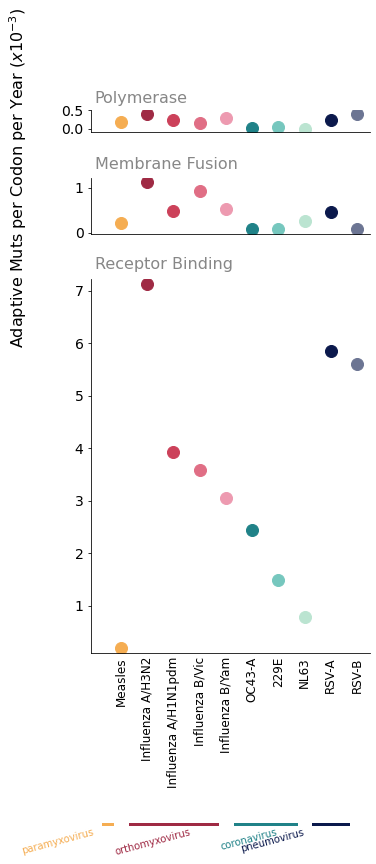

In [330]:
compare_viruses_adaptive_rate(['measles', 'h3n2', 'h1n1pdm', 'vic', 'yam', 'oc43', '229e', 'nl63', 'rsv'], 
                              exclude= ['oc43_b'],
                              bootstrap=False, outgroup_type='consensus') 